In [1]:
# conda create --name pes-env python=3.11.4 numpy scipy matplotlib pyserial control ipykernel

import time
import numpy as np
import matplotlib.pyplot as plt
import control as ct
import scipy as sp
from SerialStream import SerialStream


def estimate_frf_and_coherence(x, y, fs, window, nperseg, noverlap):
    # Estimate cross spectral density and power spectral densities
    freq, Pxy = sp.signal.csd(x, y, fs=fs, window=window, nperseg=nperseg, noverlap=noverlap)
    _, Pxx = sp.signal.csd(x, x, fs=fs, window=window, nperseg=nperseg, noverlap=noverlap)
    _, Pyy = sp.signal.csd(y, y, fs=fs, window=window, nperseg=nperseg, noverlap=noverlap)

    # Calculate frequency response function
    g = Pxy / Pxx

    # Calculate coherence
    c = np.abs(Pxy) ** 2 / (Pxx * Pyy)

    # Truncate DC (freq=0) to avoid divide-by-zero issues
    return freq[1:], g[1:], c[1:]


def get_step_resp_from_frd(G_frd, f_max_hz):
    # Extract complex frequency response
    g = G_frd.magnitude.flatten() * np.exp(1j * G_frd.phase.flatten())

    # Reconstruct DC (simulate symmetry at zero freq)
    g_dc = g[0]  # Use g[0] again as a placeholder for DC
    g = np.insert(g, 0, g_dc)  # Prepend DC component

    # Extend frequency vector accordingly
    freq = G_frd.frequency / (2 * np.pi)
    freq = np.insert(freq, 0, 0.0)

    # Zero out above f_max_hz
    g[freq > f_max_hz] = 0

    # Construct full symmetric spectrum
    g_full = np.concatenate([g, np.conj(g[-2:0:-1])])

    # Step response is cumulative sum of real part of IFFT
    step_resp = np.cumsum(np.real(np.fft.ifft(g_full)))

    return step_resp

In [2]:
port = "/dev/ttyUSB0" # "COM12"
baudrate = int(2e6)

# Initialize the SerialStream object
try:
    serialStream.reset()
    print("Resetting existing serialStream object.")
except Exception as e:
    serialStream = SerialStream(port, baudrate)
    print("Creating new serialStream object.")

# Starting the stream
serialStream.start()
while serialStream.is_busy_flag():
    time.sleep(0.1)

# Accessing the data
try:
    data = serialStream.get_data()
except Exception as e:
    print("Data Stream not triggered.")
    exit()

# Save the data
file_name = "data_pi_controller_00.npz"
np.savez(file_name, **data)

# Load the data
loaded = np.load(file_name)
data = {"time": loaded["time"], "values": loaded["values"]}

Creating new serialStream object.
SerialStream waiting for 3.00 seconds...
SerialStream started, logging 6 signals
             logging for 2.00 seconds...
             logging for 4.00 seconds...
             logging for 6.00 seconds...
             logging for 8.00 seconds...
             logging for 10.00 seconds...
             logging for 12.00 seconds...
             logging for 14.00 seconds...
             logging for 16.00 seconds...
             logging for 18.00 seconds...
             logging for 20.00 seconds...
SerialStream ended with 0.30 seconds timeout
             logged for 20.00 seconds
             measured 240000 datapoints


(0.0, 601.2000000040985)

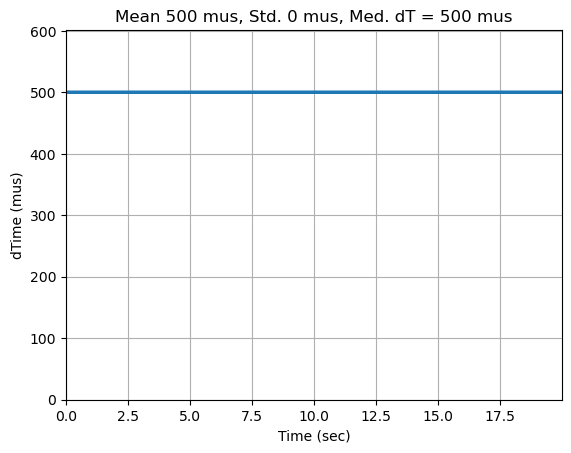

In [3]:
# Evaluate time

Ts = np.mean(np.diff(data["time"]))

plt.figure(1)
plt.plot(data["time"][:-1], np.diff(data["time"]) * 1e6)
plt.grid(True)
plt.title(f"Mean {np.mean(np.diff(data['time']) * 1e6):.0f} mus, " f"Std. {np.std(np.diff(data['time']) * 1e6):.0f} mus, " f"Med. dT = {np.median(np.diff(data['time']) * 1e6):.0f} mus")
plt.xlabel("Time (sec)")
plt.ylabel("dTime (mus)")
plt.xlim([0, data["time"][-2]])
plt.ylim([0, 1.2 * np.max(np.diff(data["time"]) * 1e6)])

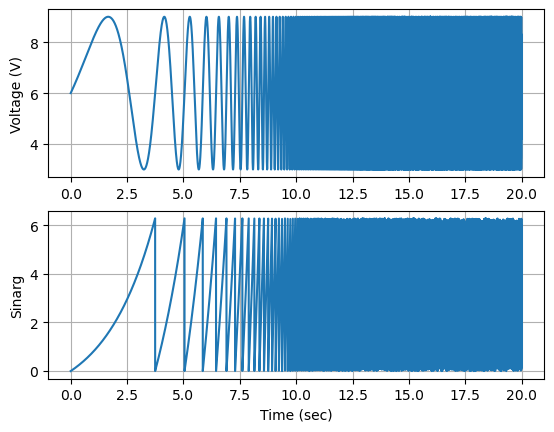

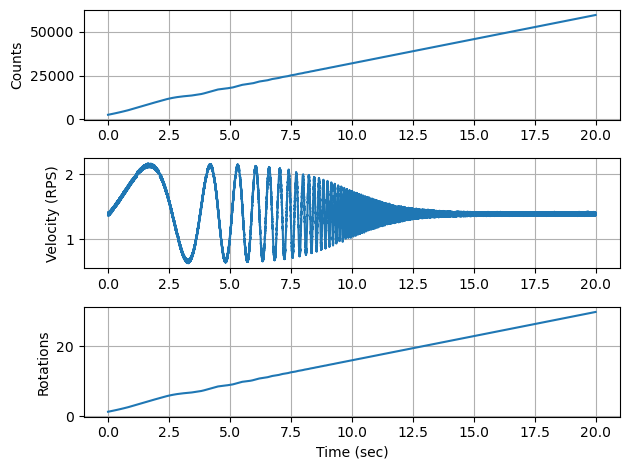

In [4]:
# Evaluate the data

# Defining the indices for the data columns
ind = {}
ind["counts"] = 0
ind["velocity"] = 1
ind["rotations"] = 2
ind["voltage"] = 3
ind["sinarg"] = 4

plt.figure(2)
plt.subplot(2, 1, 1)
plt.plot(data["time"], data["values"][:, ind["voltage"]])
plt.grid(True)
plt.ylabel("Voltage (V)")
plt.subplot(2, 1, 2)
plt.plot(data["time"], data["values"][:, ind["sinarg"]])
plt.grid(True)
plt.ylabel("Sinarg")
plt.xlabel("Time (sec)")

plt.figure(3)
plt.subplot(3, 1, 1)
plt.plot(data["time"], data["values"][:, ind["counts"]])
plt.grid(True)
plt.ylabel("Counts")
plt.subplot(3, 1, 2)
plt.plot(data["time"], data["values"][:, ind["velocity"]], label="Actual")
plt.grid(True)
plt.ylabel("Velocity (RPS)")
plt.subplot(3, 1, 3)
plt.plot(data["time"], data["values"][:, ind["rotations"]])
plt.grid(True)
plt.ylabel("Rotations")
plt.xlabel("Time (sec)")
plt.tight_layout()

Measured DC-Gain: -12.73 dB


Text(0, 0.5, 'Magnitude (abs)')

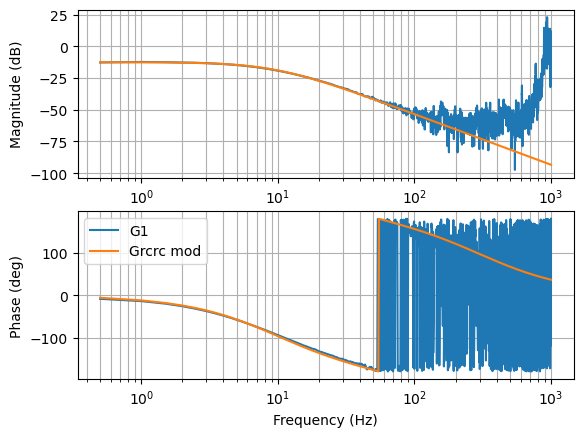

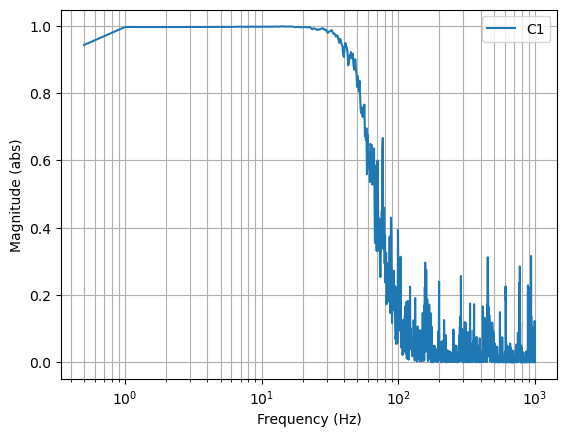

In [5]:
# Frequency response estimation
Nest = round(2.0 / Ts)
koverlap = 0.9
Noverlap = round(koverlap * Nest)
window = sp.signal.windows.hann(Nest)
inp = np.diff(data["values"][:, ind["voltage"]])
out = np.diff(data["values"][:, ind["velocity"]])
freq, g, c = estimate_frf_and_coherence(inp, out, fs=1 / Ts, window=window, nperseg=Nest, noverlap=Noverlap)
G = ct.frd(g, 2 * np.pi * freq)
C = ct.frd(c, 2 * np.pi * freq)

# Print the DC-Gain
print(f"Measured DC-Gain: {ct.mag2db(abs(g[0])):.2f} dB")

# Model the plant as transfer function
s = ct.tf([1, 0], 1)
# K = ct.db2mag(0) # adjust values here
# n = 1
# T1 = 1.0 / (2 * np.pi * 100)
# Tt = 0.1
K = ct.db2mag(-12.5)
n = 2
T1 = 1.0 / (2 * np.pi * 9.5)
Tt = 1e-3
G_mod = K / (T1 * s + 1) ** n

# Add dead time using 1st-order Pade approximation
num, den = ct.pade(Tt, 1)
G_mod = G_mod * ct.tf(num, den)

mag_G, phase_G, _ = ct.frequency_response(G, 2 * np.pi * freq)
mag_G_mod, phase_G_mod, _ = ct.frequency_response(G_mod, 2 * np.pi * freq)

plt.figure(4)
plt.subplot(2, 1, 1)
plt.semilogx(freq, 20 * np.log10(mag_G.flatten()), label="G1")
plt.semilogx(freq, 20 * np.log10(mag_G_mod.flatten()), label="Grcrc mod")
plt.grid(True, which="both", axis="both")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.subplot(2, 1, 2)
plt.semilogx(freq, 180 / np.pi * np.arctan2(np.sin(phase_G.flatten()), np.cos(phase_G.flatten())), label="G1")
plt.semilogx(freq, 180 / np.pi * np.arctan2(np.sin(phase_G_mod.flatten()), np.cos(phase_G_mod.flatten())), label="Grcrc mod")
plt.grid(True, which="both", axis="both")
plt.legend(loc="best")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Phase (deg)")

plt.figure(5)
plt.semilogx(freq, C.magnitude.flatten(), label="C1")
plt.grid(True, which="both", axis="both")
plt.legend(loc="best")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (abs)")

PI Controller P gain: 6.78
PI Controller I gain: 269.84


(0.0, 0.2)

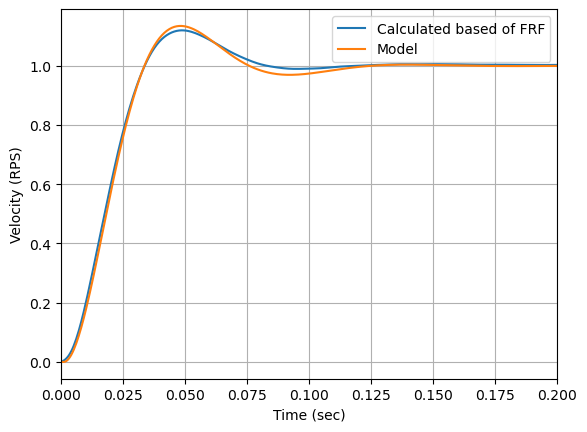

In [6]:
# Chien-Hrones-Reswick PI tuning
# Reference: Chien, Hrones, Reswick (1952), Åström & Hägglund, Seborg et al.
# Assumed model: First-order plus dead time (FOPDT):
#
#   G(s) = K / (T1*s + 1) * e^(-Tt*s)
#
# Approximation of your actual plant:
# - The n-lag system is approximated to an equivalent FOPDT using:
# - These formulas are empirically derived from Åström & Hägglund, based on matching step response behavior.
#   Purpose: This allows the use of classical CHR PI tuning formulas based on FOPDT.
#
#   T1_approx = T1 * (n + 1)/2
#   Tt_approx = T1 * (n - 1)/2 + Tt
#
# Tuning for ~20% overshoot (faster tuning)
#
#   Kp = 0.6 * T1 / (Tt * K)
#   Ti = T1
#
# - Here the plant approximation (FOPDT) is used.

# Approximate equivalent dominant time constant
T1_approx = T1 * (n + 1) / 2
# Approximate effective delay
Tt_approx = T1 * (n - 1) / 2 + Tt

# PI Controller
Kp = 0.6 * T1_approx / (Tt_approx * K)
Ti = T1_approx
Ki = Kp / Ti
C = Kp + Ki / s

# Controller Gains
print(f"PI Controller P gain: {Kp:.2f}")
print(f"PI Controller I gain: {Ki:.2f}")

# Closed-loop systems
T = ct.feedback(ct.frd(C, G.frequency) * G, 1)
T_mod = ct.feedback(C * G_mod, 1)

# Step responses
f_max = 80
step_time = np.arange(Nest) * Ts
step_resp = get_step_resp_from_frd(T, f_max)

_, step_resp_mod = ct.step_response(T_mod, step_time)

plt.figure(6)
plt.plot(step_time, step_resp, label="Calculated based of FRF")
plt.plot(step_time, step_resp_mod, label="Model")
plt.grid(True)
plt.xlabel("Time (sec)")
plt.ylabel("Velocity (RPS)")
plt.legend()
plt.xlim([0, 0.2])